In [1]:
import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))


In [2]:
import torch
import numpy as np


env_name = "button-press-topdown-v2"
# env_name = "box-close-v2"
# env_name = "dial-turn-v2"
# env_name = "sweep-v2"
exp_name = "CUDA-01-00"
pair_algo = "ternary-500"
# reward_model_algo = "MR-exp"
reward_model_algo = "MR-linear"
test_pair_algo = "ternary-500-aug-10000-conf-0.999"

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

TRAJECTORY_LENGTH = 25

In [3]:
policy_rate_dict = {
    "button-press-topdown-v2": {
        "ternary-500-aug-10000-conf-0.999": 0.1,
    }
}

In [4]:
from data_generation.data_research import predict_rewards
from data_loading.load_data import load_dataset


def predict_only_rewards(
    env_name,
    exp_name,
    pair_algo,
    reward_model_algo,
):
    result = predict_rewards(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=pair_algo,
        reward_model_algo=reward_model_algo,
    )

    pred_reward_list = [r for (_, r, _, _) in result]
    pred_reward_list = np.array(pred_reward_list)

    return pred_reward_list

# True reward
dataset = load_dataset(
    env_name=env_name,
)
cumsum = np.cumsum(dataset["rewards"], dtype=np.float64)
average_reward = np.mean(dataset["rewards"])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def get_reward_from_cumsum(start, end):
    """
    Get the reward from the cumulative sum between start and end indices.
    """

    if start == 0:
        return cumsum[end - 1]
    else:
        return cumsum[end - 1] - cumsum[start - 1]

def get_total_reward(s, e, reward_cumsum):
    return reward_cumsum[e - 1] - (reward_cumsum[s - 1] if s > 0 else 0)

def get_bucket_index(reward, bucket_ranges):
    for i, (low, high) in enumerate(bucket_ranges):
        if low <= reward <= high:  
            return i
    return None 

In [5]:
from matplotlib import gridspec, pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from data_loading.load_data import load_pair

def eval_feedbacks(feedbacks, test_pair_algo="default", unlabel_pair="unlabel-100000"):
    traj_truth_rewards = []
    unlabel_pairs = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=unlabel_pair,
    )
    raw_traj_truth_rewards = []
    for p in unlabel_pairs:
        (s0, e0), (s1, e1), _ = p
        raw_traj_truth_rewards.append(get_reward_from_cumsum(s0, e0))
        raw_traj_truth_rewards.append(get_reward_from_cumsum(s1, e1))

    total = 0
    correct = 0

    for p in feedbacks:
        (s0, e0), (s1, e1), mu = p

        r0 = get_reward_from_cumsum(s0, e0)
        r1 = get_reward_from_cumsum(s1, e1)

        if mu != 0.5:
            total += 1
        if mu == 1.0 and r0 < r1:
            correct += 1
        elif mu == 0.0 and r0 > r1:
            correct += 1

        traj_truth_rewards.append((r0, r1))
        traj_truth_rewards.append((r1, r0))

    accuracy = correct / total if total > 0 else 0.0
    print(f"Total: {total}, Correct: {correct}, Accuracy: {accuracy:.4f}")

    # 히스토그램 설정
    bins = 25
    bin_edges = np.linspace(0, 250, bins + 1)

    r0_list = [r0 for r0, _ in traj_truth_rewards]
    r1_list = [r1 for _, r1 in traj_truth_rewards]

    observed, _, _ = np.histogram2d(r0_list, r1_list, bins=[bin_edges, bin_edges])
    observed = observed.T

    traj_hist, _ = np.histogram(raw_traj_truth_rewards, bins=bin_edges)
    traj_prob = traj_hist / np.sum(traj_hist)

    expected = np.outer(traj_prob, traj_prob) * np.sum(observed)
    ratio = observed / (expected + 1e-8)
    gamma = 0.3
    adjusted_ratio = np.power(ratio, gamma)

    # KL Divergence 계산 함수
    def compute_kl_divergence(observed, expected, eps=1e-8):
        P = observed / (np.sum(observed) + eps)
        Q = expected / (np.sum(expected) + eps)
        mask = P > 0
        P_masked = P[mask]
        Q_masked = Q[mask]
        return np.sum(P_masked * np.log(P_masked / (Q_masked + eps)))

    kl = compute_kl_divergence(observed, expected)

    # 하단 텍스트
    caption = f"KL: {kl:.4f} | Pair Acc: {accuracy:.4f}"

    try:
        policy_success_rate = policy_rate_dict[env_name][f"{test_pair_algo}"]
        caption += f" | Policy Success Rate: {policy_success_rate:.4f}"
    except KeyError:
        pass  # 값이 없으면 무시

    # r0 - r1 절댓값 리스트
    r_diff_list = [abs(r0 - r1) for r0, r1 in traj_truth_rewards]

    # 시각화
    fig = plt.figure(figsize=(6, 7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.3)

    # 상단 2D 히트맵
    ax0 = plt.subplot(gs[0])
    im = ax0.imshow(
        adjusted_ratio, origin="lower", aspect="equal",
        extent=[0, 250, 0, 250], cmap="Blues", vmin=0.0, vmax=2.0
    )
    plt.colorbar(im, ax=ax0, label="Observed / Expected Ratio")
    ax0.set_xlabel("Reward 0")
    ax0.set_ylabel("Reward 1")
    ax0.set_title(
        "Reward Pair Density Ratio (Obs / Exp) under Independence\n"
        f"Pair: {test_pair_algo}",
        fontsize=11
    )

    # 하단 |r0 - r1| 히스토그램
    ax1 = plt.subplot(gs[1])
    hist_diff, bins_diff = np.histogram(r_diff_list, bins=25, range=(0, 250))
    ax1.bar(bins_diff[:-1], hist_diff, width=(bins_diff[1] - bins_diff[0]), align='edge', color='gray')
    ax1.set_xlim(0, 250)
    ax1.set_xlabel("|Reward 0 - Reward 1|")
    ax1.set_ylabel("Count")
    ax1.set_title("Histogram of Absolute Reward Differences")

    # 하단 텍스트
    plt.figtext(0.5, 0.01, caption, ha="center", fontsize=9)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

In [6]:
from collections import defaultdict
import seaborn as sns

def draw_bucket_distribution(bucketwise_rewards, title):
    plt.figure(figsize=(10, 6))
    k = len(bucketwise_rewards)
    for b in range(k):
        rewards = bucketwise_rewards[b]
        if rewards:
            # KDE 곡선
            sns.kdeplot(rewards, label=f"Bucket {b}", linewidth=1)

            # 평균값
            mean_val = np.mean(rewards)
            max_density = sns.kdeplot(rewards).get_lines()[-1].get_data()[1].max()

            # 텍스트 위치: (x=mean, y=곡선 최고점 근처 또는 적당한 위치)
            plt.text(mean_val, max_density * 1.05, f"B{b}\nμ={mean_val:.2f}",
                    ha='center', va='bottom', fontsize=8, color='black')

    plt.xlabel("Trajectory Reward")
    plt.ylabel("Density")
    plt.title(f"Reward Distribution by Bucket ({title})")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharex=True, sharey=True)

    for b in range(k):
        ax = axes[b // 5][b % 5]
        rewards = bucketwise_rewards[b]
        if rewards:
            ax.hist(rewards, bins=30, color='skyblue', edgecolor='black')
            ax.set_title(f"Bucket {b}\nμ={np.mean(rewards):.2f}")
        else:
            ax.set_title(f"Bucket {b} (empty)")

    plt.suptitle(f"Bucket-wise Reward Histogram ({title})")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def eval_buckets(
    env_name, 
    exp_name, 
    buckets, 
    result,
    feedbacks = None,
    aug_pair_algo = None,
):
    data = np.array(result)
    mean = data[:, 1]
    std = data[:, 2]
    var = std**2
    mean_cum = np.cumsum(mean, dtype=np.float64)
    var_cum = np.cumsum(var, dtype=np.float64)

    # 1. buckets 별 분포 그리기
    k = len(buckets)
    for i in range(k):
        buckets[i] = sorted(buckets[i], key=lambda x: x[1])
    bucket_ranges = [(buckets[i][0][1], buckets[i][-1][1]) for i in range(k)]

    for i, bucket_range in enumerate(bucket_ranges):
        print(f"Bucket {i} ({len(buckets[i])}): Range = {bucket_range[0]:.2f} to {bucket_range[1]:.2f}")

    bucket_trajectories = set()
    for i in range(k):
        for j in range(len(buckets[i])):
            s, e = buckets[i][j][0]
            bucket_trajectories.add((s, e))
    
    bucket_trajectories = list(bucket_trajectories)
    print(f"Total {len(bucket_trajectories)} train trajectories")

    bucketwise_rewards_train = [[] for _ in range(k)]
    for s, e in bucket_trajectories:
        r_bucket = get_total_reward(s, e, mean_cum)
        r_dist = get_total_reward(s, e, mean_cum)

        b = get_bucket_index(r_bucket, bucket_ranges)
        if b is not None:
            bucketwise_rewards_train[b].append(r_dist)

    draw_bucket_distribution(bucketwise_rewards_train, title="Predicted Reward")
    
    # 2. bucket 별 true reward 분포 그리기
    bucketwise_rewards = [[] for _ in range(k)]
    for s, e in bucket_trajectories:
        r_bucket = get_total_reward(s, e, mean_cum)
        r_dist = get_total_reward(s, e, cumsum)

        b = get_bucket_index(r_bucket, bucket_ranges)
        if b is not None:
            bucketwise_rewards[b].append(r_dist)
    draw_bucket_distribution(bucketwise_rewards, title="True Reward")

    # 3. 각 bucket pair에 대해서 개수, 정답률 분포 그리기
    if feedbacks is not None:
        print(f"Number of feedbacks: {len(feedbacks)}")
        bucket_dict = defaultdict(list)
        bucket_matrix = np.zeros((k, k), dtype=int)

        for (s0, e0), (s1, e1), _ in feedbacks:
            # 예측 reward로 bucket 인덱스 추정
            r0 = get_total_reward(s0, e0, mean_cum)
            r1 = get_total_reward(s1, e1, mean_cum)
            b0 = get_bucket_index(r0, bucket_ranges)
            b1 = get_bucket_index(r1, bucket_ranges)

            if b0 is None or b1 is None or b0 == b1:
                continue

            pred_mu = 1.0 if b1 > b0 else 0.0 if b1 < b0 else 0.5

            # 실제 reward로 정답 여부 확인
            real_r0 = get_reward_from_cumsum(s0, e0)
            real_r1 = get_reward_from_cumsum(s1, e1)
            real_mu = 1.0 if real_r1 > real_r0 else 0.0 if real_r1 < real_r0 else 0.5

            correct = int(pred_mu == real_mu)

            # 버킷 정렬 및 기록
            i, j = sorted([b0, b1])
            bucket_dict[(i, j)].append(correct)
            bucket_matrix[i, j] += 1

        # 정확도 계산
        heat = np.full((k, k), np.nan)
        success_rate_i_j = []

        for (i, j), results in bucket_dict.items():
            acc = np.mean(results)
            heat[i, j] = acc
            success_rate_i_j.append((i, j, acc))

        # 전체 평균 정확도 출력
        all_accs = [acc for _, _, acc in success_rate_i_j]
        overall_accuracy = np.mean(all_accs) if all_accs else 0.0
        print(f"Overall Pairwise Accuracy: {overall_accuracy:.4f}")

        # 정확도 히트맵
        plt.figure(figsize=(5, 4))
        sns.heatmap(heat, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True,
                    xticklabels=range(k), yticklabels=range(k), annot_kws={"size": 4})
        plt.title("Pairwise Accuracy Heatmap")
        plt.xlabel("Bucket j")
        plt.ylabel("Bucket i")
        plt.tight_layout()
        plt.show()

        # 분포 히트맵
        plt.figure(figsize=(6, 5))
        sns.heatmap(bucket_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f"B{j}" for j in range(k)],
                    yticklabels=[f"B{i}" for i in range(k)])
        plt.xlabel("Bucket j (r1)")
        plt.ylabel("Bucket i (r0)")
        plt.title("Confident Pair Distribution across Buckets")
        plt.tight_layout()
        plt.show()

    # 4. bucket 별 aug_pair_algo로 학습된 reward model로 예측한 reward 분포 그리기
    if aug_pair_algo is not None:
        aug_predicted_rewards = predict_only_rewards(
            env_name=env_name,
            exp_name=exp_name,
            pair_algo=aug_pair_algo,
            reward_model_algo="MR-linear",
        )
        aug_predicted_rewards_cumsum = np.cumsum(aug_predicted_rewards, dtype=np.float64)

        
        bucketwise_rewards = [[] for _ in range(k)]
        for s, e in bucket_trajectories:
            r_bucket = get_total_reward(s, e, mean_cum)
            r_dist = get_total_reward(s, e, aug_predicted_rewards_cumsum)

            b = get_bucket_index(r_bucket, bucket_ranges)
            if b is not None:
                bucketwise_rewards[b].append(r_dist)
        draw_bucket_distribution(bucketwise_rewards, title="Augmented Predicted Reward")




In [ ]:
from data_generation.data_research import divide_into_buckets
from data_loading.load_data import load_pair


def main():
    feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=test_pair_algo,
    )

    eval_feedbacks(feedbacks, test_pair_algo=test_pair_algo)

    feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo="ternary-500-aug-10000-bucket-20-uncert-3.1",
    )

    eval_feedbacks(feedbacks, test_pair_algo="ternary-500-aug-10000-bucket-20-uncert-3.1")
    


    # result = predict_rewards(
    #     env_name=env_name,
    #     exp_name=exp_name,
    #     pair_algo="ternary-500",
    #     reward_model_algo="MR-exp",
    # )

    # buckets = divide_into_buckets(
    #     env_name=env_name,
    #     exp_name=exp_name,
    #     result=result,
    #     unlabel_pair_algo="unlabel-100000",
    #     min_k=10,
    #     max_k=20,
    #     use_knn=True,
    # )

    # eval_buckets(
    #     env_name=env_name,
    #     exp_name=exp_name,
    #     buckets=buckets,
    #     result=result,
    #     # feedbacks=feedbacks,
    #     # aug_pair_algo=test_pair_algo,
    #     feedbacks=None,
    #     aug_pair_algo=None,
    # )

Total: 10375, Correct: 10363, Accuracy: 0.9988


/tmp/ipykernel_2618131/2323729365.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])


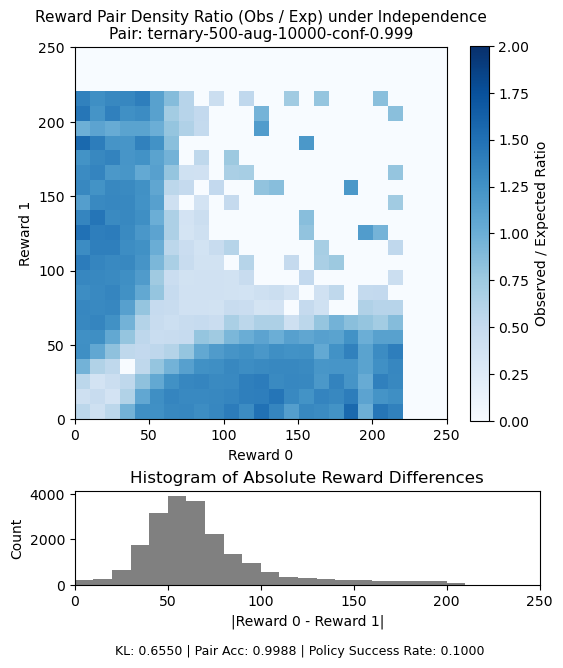

Total: 9485, Correct: 9189, Accuracy: 0.9688


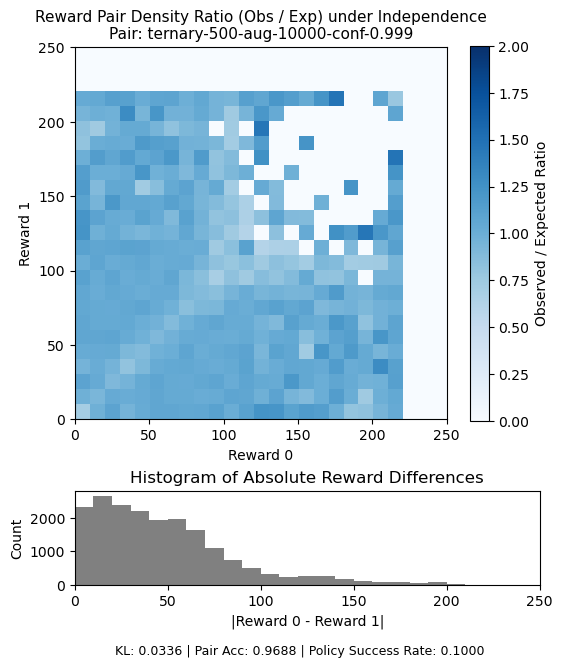

In [8]:
main()